# Light curve plotting

In [3]:
from db import query
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from scipy.interpolate import CubicSpline
import seaborn as sns 

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}

In [4]:
def semi_major_axis(q, e):
    '''
    Calculate the semi-major axis, a.
    '''
    return q/(1 - e)

def reduced_magnitude(m, hd, td):
    return m - 5.0*np.log10(hd*td)

In [5]:
N_obs = 1000

stmt = """
SELECT
    mpc.ssObjectId, mpc.e, mpc.q, mpc.mpcG, mpc.mpcH,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err,
    sso.g_H_gG12_Cov, sso.g_Ndata, sso.r_H, sso.r_Herr,
    sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov, sso.r_Ndata,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
    sso.i_Ndata, sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err,
    sso.z_H_zG12_Cov, sso.z_Ndata
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs >= {} ORDER by sso.ssObjectId
""".format(str(N_obs))

uniqueObj = query(stmt).to_table()
uniqueObj

ssObjectId,e,q,mpcG,mpcH,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,g_Ndata,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,r_Ndata,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,i_Ndata,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov,z_Ndata
,,AU,,mag,d,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,
int64,float64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32
-9217466392671047318,0.14236387557684574,2.361473543230547,0.15,14.48,3099.2915,2866,15.203103,0.00038897144,0.4550666,0.0040478734,7.9422597e-07,461,14.554703,0.00021039916,0.48015854,0.0020262992,1.7115104e-07,958,14.354623,0.00025000537,0.4709413,0.0025779733,2.3757198e-07,974,14.407989,0.0006071515,0.51356506,0.005866336,1.1365114e-06,473
-9212449919165436923,0.1783349289362343,45.60417410237429,0.15,6.55,3297.8752,1058,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0
-9211286014772213856,0.0658162997382177,2.889876412979229,0.15,16.54,3615.123,1766,17.275288,0.00289577,0.61713177,0.01509817,3.64732e-05,260,16.621004,0.0016441342,0.5858086,0.008620237,1.1435597e-05,537,16.41983,0.0020172396,0.5698511,0.010459836,1.702569e-05,562,16.475334,0.004990022,0.5678376,0.024085298,0.000110812514,407
-9208533592888360514,0.06660949805582513,2.9573803920849002,0.15,14.64,3169.8425,1055,15.380815,0.0022028869,0.6222429,0.011123902,2.345728e-05,132,14.729256,0.0012424011,0.6160314,0.0063005416,7.4654936e-06,288,14.525853,0.0013949565,0.59334964,0.007084308,9.326134e-06,287,14.582087,0.0024085627,0.6059947,0.012006525,2.7753556e-05,348
-9198319934054407073,0.13681691368963053,4.501341205953987,0.15,15.04,3583.9685,1168,15.600638,0.033053376,0.6629971,0.16308436,0.0053563826,150,15.099949,0.01754772,0.5274068,0.08516475,0.0014810191,384,14.999957,0.019796612,0.6277017,0.09958866,0.001946137,357,14.936385,0.032379147,0.32291257,0.1458437,0.004648534,277
-9194898143939193851,0.1496917703172324,1.9049739263017507,0.15,19.75,3608.2827,1087,20.481665,0.0051086065,0.47970673,0.038747966,-9.224497e-05,182,19.828856,0.003940334,0.4659227,0.031715937,-9.142674e-05,380,19.626135,0.0052751894,0.5151599,0.04298533,-0.00017211038,336,19.677433,0.010288601,0.44917247,0.08134415,-0.00049515144,189
-9188694588940446479,0.09016324668058376,2.9191570484487683,0.15,16.2,3161.992,1336,16.928938,0.0024743942,0.563455,0.017895207,1.0086775e-05,204,16.277994,0.0013258602,0.5913851,0.009256212,3.4208501e-06,440,16.081295,0.0016639538,0.58195555,0.012105747,4.862953e-06,448,16.12351,0.0040396308,0.5026726,0.025741415,5.7220892e-05,244
-9186168674478550259,0.23344542475533744,2.0969850735060525,0.15,15.54,2920.819,2064,16.26421,0.0009085277,0.5034483,0.009313577,3.7164054e-06,335,15.6143055,0.00045167241,0.5149425,0.0049309437,1.8081512e-07,681,15.414917,0.0005772725,0.50797635,0.00510145,7.0264207e-07,687,15.471048,0.0011641541,0.5433281,0.009459758,1.9743543e-06,361


In [7]:
a = semi_major_axis(uniqueObj['q'], uniqueObj['e'])

neo = (uniqueObj['q'] < 1.3)

not_near_mars = uniqueObj['q'] > 1.666
main_belt = (a > 2.0) & (a < 3.2) & not_near_mars
main_belt_2k = main_belt

inner_belt = (a > 2.0) & (a < 2.5) & not_near_mars
mid_belt = (a >= 2.5) & (a < 2.82) & not_near_mars
outer_belt = (a > 2.82) & (a < 3.25) & not_near_mars

JT = (a > 4.6) & (a < 5.5) & (uniqueObj['e'] < 0.3)
JT_2k = (uniqueObj['numObs'] > N_obs) & JT

TNO = (a > 30.1)
TNO_2k = (uniqueObj['numObs'] > N_obs) & TNO

print('There are %d NEOs in this sample!' % len(a[neo]))
print('There are %d asteroids in this sample!' % len(a[main_belt]))
print('There are %d Jupiter Trojans in this sample!' % len(a[JT]))
print('There are %d TNOs in this sample!' % len(a[TNO]))

all = neo + main_belt + JT + TNO

There are 3 NEOs in this sample!
There are 4821 asteroids in this sample!
There are 713 Jupiter Trojans in this sample!
There are 77 TNOs in this sample!


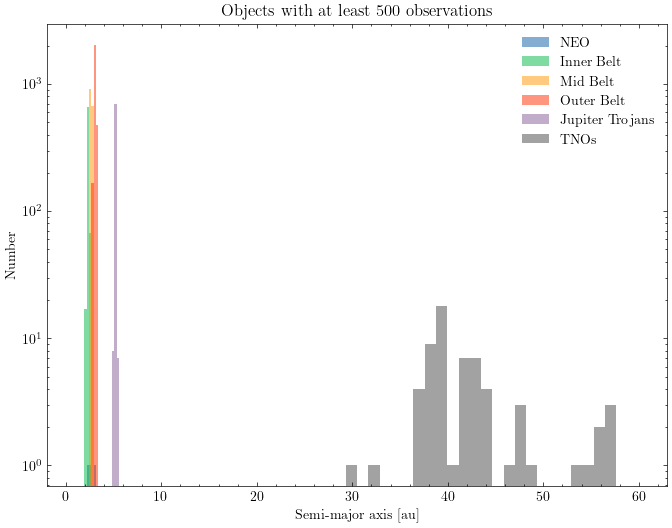

In [8]:
plt.figure(figsize=(8,6))

h = plt.hist(a[neo], bins=25, range=(1, 7),
             label='NEO', alpha=.5)

h = plt.hist(a[inner_belt], bins=25, range=(1, 7),
             label='Inner Belt', alpha=.5)

h = plt.hist(a[mid_belt], bins=25, range=(1, 7),
             label='Mid Belt', alpha=.5)
h = plt.hist(a[outer_belt], bins=25, range=(1, 7),
             label='Outer Belt', alpha=.5)

h = plt.hist(a[JT], bins=25, range=(1, 7),
             label='Jupiter Trojans', alpha=.5)
h = plt.hist(a[TNO], bins=50, range=(1, 60), label='TNOs', alpha=.5)

plt.xlabel('Semi-major axis [au]')
plt.ylabel('Number')
plt.yscale('log')
plt.legend()
plt.title("Objects with at least 500 observations")
plt.show()

In [9]:
stmt = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
LIMIT 1000000
""".format(tuple(uniqueObj['ssObjectId'][all]))

indivObs = query(stmt).to_table()
# Add reduced magnitude column.
indivObs.add_column(reduced_magnitude(indivObs["mag"], indivObs['heliocentricDist'], indivObs['topocentricDist']), name='reducedMag')

In [11]:
plt.figure(figsize=(6,4))
iObj = 1
sId = uniqueObj['ssObjectId'][main_belt][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]
tmp

ssObjectId,diaSourceId,mag,magErr,band,midPointMjdTai,phaseAngle,topocentricDist,heliocentricDist,reducedMag
,,,,,d,deg,AU,AU,
int64,int64,float32,float32,str1,float64,float32,float32,float32,float32
-9211286014772213856,12620586634971262,21.69,0.05,i,61011.33964,19.53938,2.6484334,2.928868,17.241556
-9211286014772213856,14354279529954594,20.926,0.029,z,61067.30391,8.974386,2.0441694,2.9508264,17.023697
-9211286014772213856,25197082056942958,21.125,0.042,z,60661.09629,12.018025,2.1073804,2.9420042,17.163069
-9211286014772213856,37340919581574782,20.842,0.015,r,61080.15261,4.625995,1.9896007,2.956602,16.994205
-9211286014772213856,41755707125874952,22.687,0.057,g,60995.33932,19.643139,2.8638198,2.9236355,18.072655
-9211286014772213856,49725314334487392,20.643,0.017,i,61079.14234,4.952079,1.9922427,2.9561388,16.792664
-9211286014772213856,61940432633461449,22.017,0.08,i,60996.34995,19.665909,2.8502712,2.9239514,17.412718
-9211286014772213856,63470351832203959,21.952,0.046,i,60998.34789,19.700148,2.8234298,2.9245815,17.367796


<Figure size 600x400 with 0 Axes>

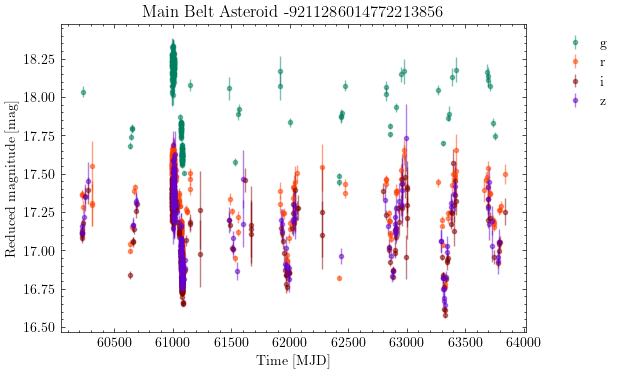

In [19]:
plt.figure(figsize=(6,4))
iObj = 1
sId = uniqueObj['ssObjectId'][main_belt][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['midPointMjdTai'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5, label=ifilt)



plt.xlabel('Time [MJD]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title(f'Main Belt Asteroid {sId}')
plt.show()

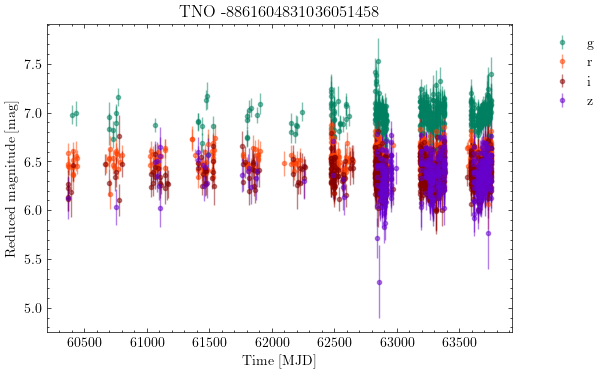

In [23]:
plt.figure(figsize=(6,4))
iObj = 1
sId = uniqueObj['ssObjectId'][TNO][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['midPointMjdTai'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5, label=ifilt)



plt.xlabel('Time [MJD]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title(f'TNO {sId}')
plt.show()

# Why is the errorbar variable?

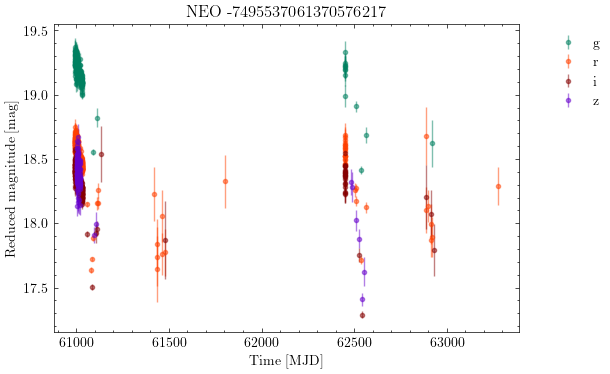

In [25]:
plt.figure(figsize=(6,4))
iObj = 1
sId = uniqueObj['ssObjectId'][neo][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['midPointMjdTai'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5, label=ifilt)



plt.xlabel('Time [MJD]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title(f'NEO {sId}')
plt.show()

# Why is the errorbar variable?